The data given is of cash deposits made in particular branches of a bank. Please go through the descriptions of variables below for conceptual understanding of the data.

Serial Number : Unique identifier for each data point relationship

Main Office : Signifies if the deposit made at main office. 0 meaning No and 1 meaning Yes

Branch Number : Identification number of certain branch or brnaches

Establishment Date and Acquired Date : Date at which bank branch was established and acquired by specific bank franchise

City, County and State : Geographical details of the bank branch

Year Deposits Variable (2013 Deposits, 2014 Deposits) : Deposit amount in US Dollars for specific branch for specific year

Objective : The objective is to predict the cash deposit amount for branches for the year of 2016 ("2016 Deposits" variable)

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta, date
import matplotlib.pyplot as plt
import math
import geopandas as gpd
import fiona.crs
from shapely.geometry import Point
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn import datasets, linear_model, metrics
from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from statsmodels.tools.eval_measures import rmse
pd.set_option('display.max_columns',None)
pd.set_option('display.max_row',None)
%matplotlib inline

# EPSG (European Petroleum Survey Group) standards are used to define CRS (Coordinate Reference System for a
# particular area -- projecting coordinates on an uneven shaped Mother Earth)
# epsg.io

In [2]:
deposit_data = pd.read_csv('/Users/pritigirishvankudre/DayX_Lockdown Practice/Bank Deposit/file.csv')

In [3]:
deposit_data.head()

,Serial Number,Main Office,Branch Number,Established Date,Acquired Date,City,County,State,2010 Deposits,2011 Deposits,2012 Deposits,2013 Deposits,2014 Deposits,2015 Deposits,2016 Deposits
0,1,0,2866,02/06/1910,11/13/2004,Wales,Waukesha,WI,21386.0,23981.0,24825.0,26908.0,30681.0,30680.0,37564
1,2,0,2867,02/28/1910,11/13/2004,Germantown,Washington,WI,55454.0,56564.0,64732.0,73523.0,81357.0,89270.0,106177
2,3,0,2868,05/06/1907,11/13/2004,Brookfield,Waukesha,WI,90882.0,104300.0,125038.0,125906.0,132501.0,137363.0,145054
3,4,0,2869,06/20/1936,11/13/2004,Pewaukee,Waukesha,WI,45674.0,49288.0,53251.0,70402.0,74742.0,73837.0,85996
4,5,0,2870,04/22/1963,11/13/2004,Waukesha,Waukesha,WI,64181.0,72217.0,69920.0,80703.0,75971.0,73225.0,81706


In [4]:
deposit_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3790 entries, 0 to 3789
Data columns (total 15 columns):
Serial Number       3790 non-null int64
Main Office         3790 non-null int64
Branch Number       3790 non-null int64
Established Date    3790 non-null object
Acquired Date       2297 non-null object
City                3790 non-null object
County              3790 non-null object
State               3790 non-null object
2010 Deposits       3050 non-null float64
2011 Deposits       3212 non-null float64
2012 Deposits       3461 non-null float64
2013 Deposits       3615 non-null float64
2014 Deposits       3734 non-null float64
2015 Deposits       3771 non-null float64
2016 Deposits       3790 non-null int64
dtypes: float64(6), int64(4), object(5)
memory usage: 444.3+ KB


In [5]:
'''
Mehtod to understand Null values distribution
'''
col_null = pd.DataFrame(deposit_data.isnull().sum()).reset_index()
col_null.columns = ['DataColumns','NullCount']
col_null['NullCount_Pct'] = round((col_null['NullCount']/deposit_data.shape[0])*100,2)
display (col_null)

,DataColumns,NullCount,NullCount_Pct
0,Serial Number,0,0.00
1,Main Office,0,0.00
2,Branch Number,0,0.00
3,Established Date,0,0.00
4,Acquired Date,1493,39.39
5,City,0,0.00
6,County,0,0.00
7,State,0,0.00
8,2010 Deposits,740,19.53
9,2011 Deposits,578,15.25


In [6]:
'''
Method to understand Unique values distribution
'''

col_uniq = pd.DataFrame(deposit_data.nunique()).reset_index()
col_uniq.columns = ['DataColumns','UniqCount']
col_uniq_cnt = pd.DataFrame(deposit_data.count(axis=0)).reset_index()
col_uniq_cnt.columns = ['DataColumns','UniqCount']
col_uniq['UniqCount_Pct'] = round((col_uniq['UniqCount']/col_uniq_cnt['UniqCount'])*100,2)
display (col_uniq)

,DataColumns,UniqCount,UniqCount_Pct
0,Serial Number,3790,100.00
1,Main Office,1,0.03
2,Branch Number,3790,100.00
3,Established Date,2027,53.48
4,Acquired Date,5,0.22
5,City,1489,39.29
6,County,299,7.89
7,State,25,0.66
8,2010 Deposits,2955,96.89
9,2011 Deposits,3104,96.64


# Data preprocessing and Null value treatment

Serial Number clomun to be dropped

Main Office column has only one unique value which is 0. We will still keep column Main Office as in future we may receuve deposit at main office.

Branch Number field is again a categorical value identifying a particualr branch. So we need to tweak this in order
to some weightage to the column and make use of it in the model.

Establishment Date column we will use to calculate the age of the branch by subtracting it from the current date.
Acquired Date we will convert into flag as 1 or 0, notfying if the branch ever acquired or not.

City, State and County we will keep as it is for EDA. Will decide if the can be dropped at model building stage.

In [7]:
deposit_data = deposit_data.drop(['Serial Number'],axis=1)
deposit_data.head()

,Main Office,Branch Number,Established Date,Acquired Date,City,County,State,2010 Deposits,2011 Deposits,2012 Deposits,2013 Deposits,2014 Deposits,2015 Deposits,2016 Deposits
0,0,2866,02/06/1910,11/13/2004,Wales,Waukesha,WI,21386.0,23981.0,24825.0,26908.0,30681.0,30680.0,37564
1,0,2867,02/28/1910,11/13/2004,Germantown,Washington,WI,55454.0,56564.0,64732.0,73523.0,81357.0,89270.0,106177
2,0,2868,05/06/1907,11/13/2004,Brookfield,Waukesha,WI,90882.0,104300.0,125038.0,125906.0,132501.0,137363.0,145054
3,0,2869,06/20/1936,11/13/2004,Pewaukee,Waukesha,WI,45674.0,49288.0,53251.0,70402.0,74742.0,73837.0,85996
4,0,2870,04/22/1963,11/13/2004,Waukesha,Waukesha,WI,64181.0,72217.0,69920.0,80703.0,75971.0,73225.0,81706


In [8]:
'''
Function to calculate age of the branch in days
'''

def date_age(x):
    
    today = date.today()
    x = datetime.strptime(x, '%m/%d/%Y').date()
    branch_age = round((today - x).days/365,0)
    return (branch_age)

deposit_data['Established Date'] = deposit_data['Established Date'].apply(lambda x: date_age(x))
deposit_data.head()

,Main Office,Branch Number,Established Date,Acquired Date,City,County,State,2010 Deposits,2011 Deposits,2012 Deposits,2013 Deposits,2014 Deposits,2015 Deposits,2016 Deposits
0,0,2866,110.0,11/13/2004,Wales,Waukesha,WI,21386.0,23981.0,24825.0,26908.0,30681.0,30680.0,37564
1,0,2867,110.0,11/13/2004,Germantown,Washington,WI,55454.0,56564.0,64732.0,73523.0,81357.0,89270.0,106177
2,0,2868,113.0,11/13/2004,Brookfield,Waukesha,WI,90882.0,104300.0,125038.0,125906.0,132501.0,137363.0,145054
3,0,2869,84.0,11/13/2004,Pewaukee,Waukesha,WI,45674.0,49288.0,53251.0,70402.0,74742.0,73837.0,85996
4,0,2870,57.0,11/13/2004,Waukesha,Waukesha,WI,64181.0,72217.0,69920.0,80703.0,75971.0,73225.0,81706


In [9]:
'''
Since Acquired Date column has only 5 unique value, we will convert it into categorical variable as whether branch
is acquired by frnachise or not.
1 - branch is acquired
0 - branch is not acquired
'''

unique = deposit_data['Acquired Date'].unique()

deposit_data['Acquired Date'].fillna(0,inplace=True)

for i in deposit_data['Acquired Date']:
    if i in unique:
        deposit_data['Acquired Date'].replace(i,1,inplace=True)

deposit_data['Acquired Date'].astype('int32').dtypes
deposit_data.head()

,Main Office,Branch Number,Established Date,Acquired Date,City,County,State,2010 Deposits,2011 Deposits,2012 Deposits,2013 Deposits,2014 Deposits,2015 Deposits,2016 Deposits
0,0,2866,110.0,1,Wales,Waukesha,WI,21386.0,23981.0,24825.0,26908.0,30681.0,30680.0,37564
1,0,2867,110.0,1,Germantown,Washington,WI,55454.0,56564.0,64732.0,73523.0,81357.0,89270.0,106177
2,0,2868,113.0,1,Brookfield,Waukesha,WI,90882.0,104300.0,125038.0,125906.0,132501.0,137363.0,145054
3,0,2869,84.0,1,Pewaukee,Waukesha,WI,45674.0,49288.0,53251.0,70402.0,74742.0,73837.0,85996
4,0,2870,57.0,1,Waukesha,Waukesha,WI,64181.0,72217.0,69920.0,80703.0,75971.0,73225.0,81706


Null Values are observed for columns

2010 Deposits ==> Need to treat by assuming the value as of 2011

2011 Deposits ==> Need to treat by assuming the value as of 2012

2012 Deposits ==> Need to treat by assuming the value as of 2013

2013 Deposits ==> Need to treat by assuming the value as of 2014

2014 Deposits ==> Need to treat by assuming the value as of 2015

2015 Deposits ==> Need to treat by assuming the value as of 2016

In [10]:
'''
Treating null values for deposit amount
'''

def null_treat(x,y):
    if math.isnan(x) is True:
        return y
    else:
        return x

deposit_data['2015 Deposits'] = deposit_data.apply(lambda x: null_treat(x['2015 Deposits'],x['2016 Deposits']),
                                                   axis=1)
deposit_data['2014 Deposits'] = deposit_data.apply(lambda x: null_treat(x['2014 Deposits'],x['2015 Deposits']),
                                                   axis=1)
deposit_data['2013 Deposits'] = deposit_data.apply(lambda x: null_treat(x['2013 Deposits'],x['2014 Deposits']),
                                                   axis=1)
deposit_data['2012 Deposits'] = deposit_data.apply(lambda x: null_treat(x['2012 Deposits'],x['2013 Deposits']),
                                                   axis=1)
deposit_data['2011 Deposits'] = deposit_data.apply(lambda x: null_treat(x['2011 Deposits'],x['2012 Deposits']),
                                                   axis=1)
deposit_data['2010 Deposits'] = deposit_data.apply(lambda x: null_treat(x['2010 Deposits'],x['2011 Deposits']),
                                                   axis=1)

In [11]:
deposit_data.head()

,Main Office,Branch Number,Established Date,Acquired Date,City,County,State,2010 Deposits,2011 Deposits,2012 Deposits,2013 Deposits,2014 Deposits,2015 Deposits,2016 Deposits
0,0,2866,110.0,1,Wales,Waukesha,WI,21386.0,23981.0,24825.0,26908.0,30681.0,30680.0,37564
1,0,2867,110.0,1,Germantown,Washington,WI,55454.0,56564.0,64732.0,73523.0,81357.0,89270.0,106177
2,0,2868,113.0,1,Brookfield,Waukesha,WI,90882.0,104300.0,125038.0,125906.0,132501.0,137363.0,145054
3,0,2869,84.0,1,Pewaukee,Waukesha,WI,45674.0,49288.0,53251.0,70402.0,74742.0,73837.0,85996
4,0,2870,57.0,1,Waukesha,Waukesha,WI,64181.0,72217.0,69920.0,80703.0,75971.0,73225.0,81706


In [12]:
deposit_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3790 entries, 0 to 3789
Data columns (total 14 columns):
Main Office         3790 non-null int64
Branch Number       3790 non-null int64
Established Date    3790 non-null float64
Acquired Date       3790 non-null int64
City                3790 non-null object
County              3790 non-null object
State               3790 non-null object
2010 Deposits       3790 non-null float64
2011 Deposits       3790 non-null float64
2012 Deposits       3790 non-null float64
2013 Deposits       3790 non-null float64
2014 Deposits       3790 non-null float64
2015 Deposits       3790 non-null float64
2016 Deposits       3790 non-null int64
dtypes: float64(7), int64(4), object(3)
memory usage: 414.7+ KB


# Understanding the outliers

In [13]:
outlier = deposit_data[['Branch Number','2010 Deposits','2011 Deposits','2012 Deposits',
                        '2013 Deposits','2014 Deposits','2015 Deposits','2016 Deposits']].copy()
#outlier['Total Deposit'] = outlier['2010 Deposits']+outlier['2011 Deposits']+outlier['2012 Deposits']+outlier['2013 Deposits']+outlier['2014 Deposits']+outlier['2015 Deposits']+outlier['2016 Deposits']

#outlier.drop(['2010 Deposits','2011 Deposits', '2012 Deposits', '2013 Deposits', '2014 Deposits','2015 Deposits',
#       '2016 Deposits'], axis=1, inplace=True)

#outlier.sort_values(by='Total Deposit',ascending=False,inplace=True)

In [14]:
def get_outliers(self):
        a_list = []
        per_75 = np.percentile(self,75)
        per_25 = np.percentile(self,25)
        iqr = per_75-per_25
        tot_75 = per_75 + (1.5*iqr)
        print ('Upper Limit of Outliers acceptance = %.2f' %(tot_75))
        tot_25 = per_25 - (1.5*iqr)
        print ('Lower Limit of Outliers acceptance = %.2f' %(tot_25))
        a_list1 = np.array(self).tolist()
        for j in a_list1:
            if j > tot_75:
                a_list.append(j)
            if j < tot_25:
                a_list.append(j)
        return a_list
        
for i in outlier[['2010 Deposits','2011 Deposits','2012 Deposits','2013 Deposits','2014 Deposits',
                  '2015 Deposits','2016 Deposits']]:
    outliers = get_outliers(outlier[i])
    print ("Total outliers in Column",outlier[i].name," =",len(outliers))
    print ("Percentatge of outliers in Column",outlier[i].name," =",round(((len(outliers)/outlier.shape[0])*100),2))
    print ("** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** **")

Upper Limit of Outliers acceptance = 126866.62
Lower Limit of Outliers acceptance = -59024.38
Total outliers in Column 2010 Deposits  = 228
Percentatge of outliers in Column 2010 Deposits  = 6.02
** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** **
Upper Limit of Outliers acceptance = 131893.12
Lower Limit of Outliers acceptance = -58875.88
Total outliers in Column 2011 Deposits  = 238
Percentatge of outliers in Column 2011 Deposits  = 6.28
** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** **
Upper Limit of Outliers acceptance = 143372.50
Lower Limit of Outliers acceptance = -59479.50
Total outliers in Column 2012 Deposits  = 246
Percentatge of outliers in Column 2012 Deposits  = 6.49
** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** **
Upper Limit of Outliers acceptance = 153515.38
Lower Limit of Outliers acceptance = -58483.62
Total outliers in Column 2013 Deposits  = 251
Percentatge of outliers in Column 2013 Deposits  = 6.62
** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** **
Upper Limit 

Mean for the column 2010 Deposits is 92871.04
Median for the column 2010 Deposits is 28096.50
Skewness for the column 2010 Deposits is 60.42


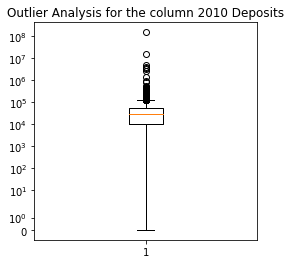

Mean for the column 2011 Deposits is 108521.94
Median for the column 2011 Deposits is 31035.00
Skewness for the column 2011 Deposits is 60.60


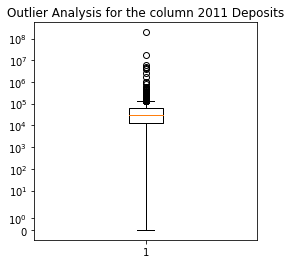

Mean for the column 2012 Deposits is 119256.69
Median for the column 2012 Deposits is 35864.50
Skewness for the column 2012 Deposits is 60.40


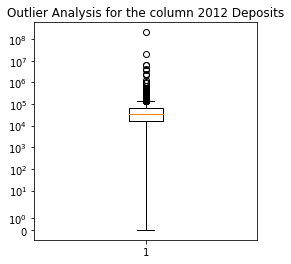

Mean for the column 2013 Deposits is 131295.95
Median for the column 2013 Deposits is 40622.50
Skewness for the column 2013 Deposits is 60.34


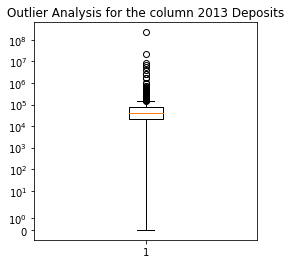

Mean for the column 2014 Deposits is 144328.71
Median for the column 2014 Deposits is 46245.00
Skewness for the column 2014 Deposits is 60.30


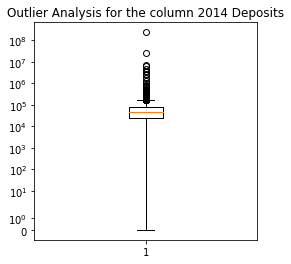

Mean for the column 2015 Deposits is 157657.84
Median for the column 2015 Deposits is 52388.00
Skewness for the column 2015 Deposits is 60.43


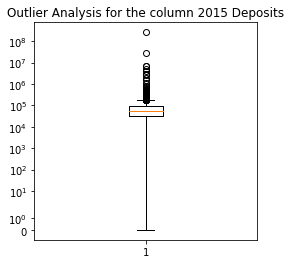

Mean for the column 2016 Deposits is 183255.80
Median for the column 2016 Deposits is 60753.00
Skewness for the column 2016 Deposits is 60.79


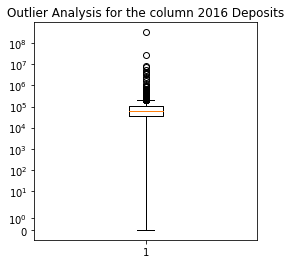

In [15]:
for i in outlier[['2010 Deposits','2011 Deposits','2012 Deposits','2013 Deposits','2014 Deposits',
                  '2015 Deposits','2016 Deposits']]:
    print ("Mean for the column %s is %.2f" %(i,outlier[i].mean()))
    print ("Median for the column %s is %.2f" %(i,outlier[i].median()))
    print ("Skewness for the column %s is %.2f" %(i,outlier[i].skew()))
    plt.figure(figsize=(4,4), frameon=True)
    plt.boxplot(x=outlier[i])
    plt.title('Outlier Analysis for the column %s' %(i))
    plt.yscale('symlog')
    plt.show()

In case of Bank deposits we could expect some branches (depending on geographic and demographic advantages) hold extravegantly high amount of deposits.
The data seems right/positive skewed as Mean > Median. At the time of model buiding we could think of treating the skewness if in case there is a need to improve on the model.

# Exploratory Data Analysis

Aspects we could cover for Bank Deposit Data are

-- Age of the branch versus total deposit

-- Top 10/Least 10 City/County/State holding the deposit

-- We could calculate overall deposit trend (increase/decrease) per branch and plot for Top 10/Least 10 branch

In [16]:
'''
-- Age of the branch versus total deposit
'''

a = deposit_data[['Branch Number','Established Date','2010 Deposits','2011 Deposits', '2012 Deposits', '2013 Deposits', '2014 Deposits',
                '2015 Deposits','2016 Deposits']].copy()

a['Total Deposit'] = a['2010 Deposits']+a['2011 Deposits']+a['2012 Deposits']+a['2013 Deposits']+a['2014 Deposits']+a['2015 Deposits']+a['2016 Deposits']

a.drop(['2010 Deposits','2011 Deposits', '2012 Deposits', '2013 Deposits', '2014 Deposits','2015 Deposits',
       '2016 Deposits'], axis=1, inplace=True)

a.sort_values(by='Total Deposit',ascending=False,inplace=True)

In [17]:
'''
converting age into bins
'''
a['age bins'] = pd.cut(a['Established Date'],10,labels=['Upto_23yr','23_42yr','42_61yr','61_80yr','80_99yr',
                                                        '99_118yr','118_137yr','137_156yr','156_175yr','175_195yr'])
a['age bins'].value_counts()

Upto_23yr    2255
23_42yr       452
42_61yr       356
80_99yr       222
99_118yr      185
61_80yr       157
118_137yr     137
137_156yr      13
156_175yr      11
175_195yr       2
Name: age bins, dtype: int64

In [18]:
b = pd.DataFrame(a.groupby(['age bins'])['Total Deposit'].sum()).reset_index().sort_values(by='Total Deposit',ascending=False)
b.columns = ['age bins','Total Deposit']
print (b)

    age bins  Total Deposit
0  Upto_23yr   2.473333e+09
1    23_42yr   2.739708e+08
2    42_61yr   2.158903e+08
4    80_99yr   1.583985e+08
5   99_118yr   1.465832e+08
6  118_137yr   1.360719e+08
3    61_80yr   8.460889e+07
9  175_195yr   3.134440e+07
8  156_175yr   2.217382e+07
7  137_156yr   9.568020e+06


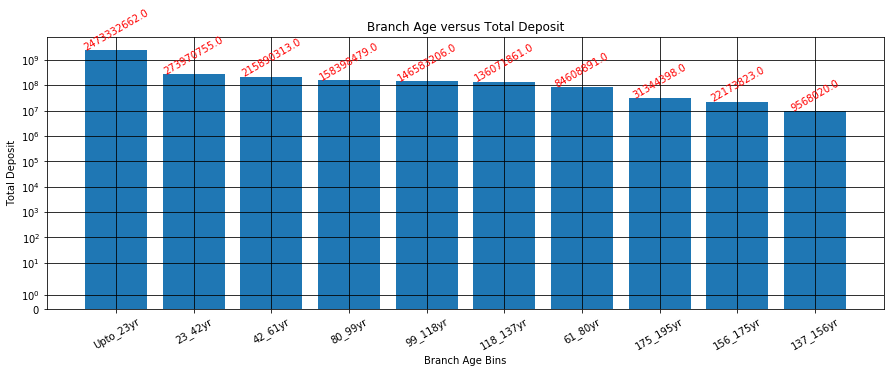

In [19]:
plt.figure(figsize=(15,5), frameon=True)
plt.bar(x=b['age bins'],height=b['Total Deposit'])
plt.grid(color='black')
plt.xticks(rotation=30)
plt.title('Branch Age versus Total Deposit')
plt.xlabel('Branch Age Bins')
plt.ylabel('Total Deposit')
plt.yscale('symlog')
for num, count in enumerate(b['Total Deposit']):
    plt.text(x=num, y=count, s=str(count), color='red', fontsize=10, horizontalalignment='center',
             verticalalignment='baseline',rotation=30)
plt.show()

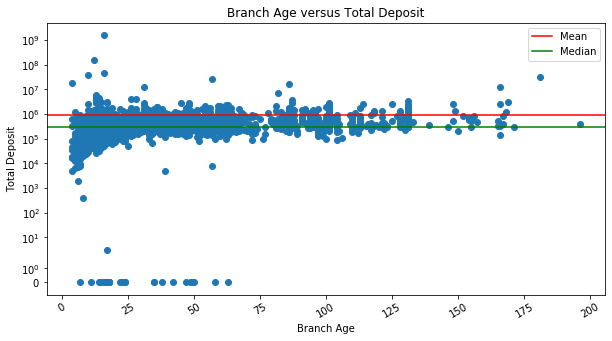

In [20]:
plt.figure(figsize=(10,5), frameon=True)
plt.scatter(x=a['Established Date'],y=a['Total Deposit'])
plt.xticks(rotation=30)
plt.title('Branch Age versus Total Deposit')
plt.xlabel('Branch Age')
plt.ylabel('Total Deposit')
plt.axhline(y=a['Total Deposit'].mean(), color='r', label='Mean')
plt.axhline(y=a['Total Deposit'].median(), color='g', label='Median')
plt.legend()
#plt.ylim(0,9999999)
#plt.xlim(0,200)
plt.yscale('symlog')
plt.show()

The observation is:
>>The newer branches with current age less than 23 years are hoding the maximum of total deposits. But if we look at the trend for Branch Age versus Total Deposit held then there is no such trend visible.

>>There are couple of brances opened in last two decades holding very high deposits. But if we compare number of branches opened during last two decades and contributing to total deposits to the older branch deposit holding then we will come to know that such old branches are less in number but holding a significant deposits.

>>The old branches must be having an additional factor of Trust but for a bank to be on growth track need to blend this Trust with modernization for a good blend of old and new.

In [21]:
'''
-- Top 10/Least 10 City/County/State holding the deposit
'''

c = deposit_data[['City','County','State','2010 Deposits','2011 Deposits','2012 Deposits','2013 Deposits',
                  '2014 Deposits','2015 Deposits','2016 Deposits']].copy()

c['Total Deposit'] = c['2010 Deposits']+c['2011 Deposits']+c['2012 Deposits']+c['2013 Deposits']+c['2014 Deposits']+c['2015 Deposits']+c['2016 Deposits']

c.drop(['2010 Deposits','2011 Deposits', '2012 Deposits', '2013 Deposits', '2014 Deposits','2015 Deposits',
       '2016 Deposits'], axis=1, inplace=True)

c.sort_values(by='Total Deposit',ascending=False,inplace=True)

In [22]:
'''
Top 10 City
'''
c_1 = pd.DataFrame(c.groupby(['City'])['Total Deposit'].sum()).reset_index().sort_values(by='Total Deposit',ascending=False)
c_1.columns = ['City','Total Deposit']
c_1.head(10)

,City,Total Deposit
876,New York City,1.717712e+09
281,Dallas,1.649745e+08
568,Indianapolis,5.055077e+07
241,Columbus,4.658347e+07
707,Los Angeles,4.557836e+07
214,Chicago,3.605928e+07
1155,San Francisco,3.498114e+07
301,Denver,3.165070e+07
139,Brooklyn,2.796383e+07
553,Houston,2.626150e+07


In [23]:
'''
Least 10 City
'''
c_1.tail(10)

,City,Total Deposit
1023,Playa Vista,13305.0
1,Abilene,3.0
635,Lake Charles,0.0
112,Boston,0.0
746,Marshall,0.0
158,Burton,0.0
1034,Port Arthur,0.0
1444,Wichita Falls,0.0
1093,River Forest,0.0
1007,Philadelphia,0.0


In [24]:
c[c['Total Deposit'] == 0]['Total Deposit'].value_counts()

0.0    47
Name: Total Deposit, dtype: int64

These 47 branches needs to be looked upon as either the data is not available or there is some serious issue with the branch reporting zero amount deposit or the branch do not facility to accept deposit.

In [25]:
'''
Grouping based on state
'''
d = pd.DataFrame(c.groupby(['State'])['Total Deposit'].sum()).reset_index().sort_values(by='Total Deposit',ascending=False)
d.columns = ['State','Total Deposit']
d.head()

,State,Total Deposit
16,NY,1.888213e+09
1,CA,5.931864e+08
21,TX,2.707363e+08
5,FL,1.303727e+08
9,IN,1.032193e+08


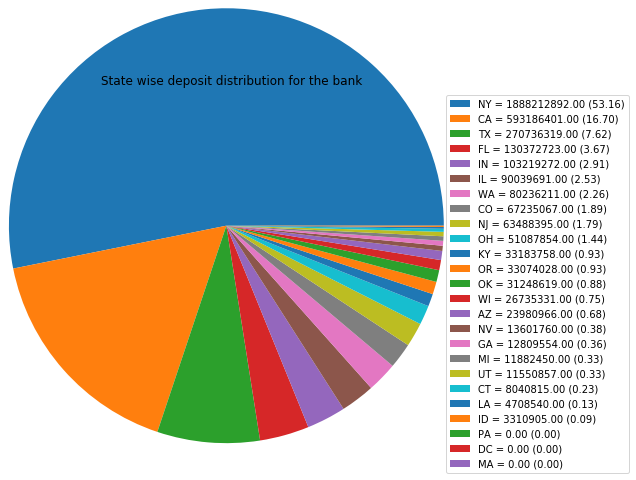

In [26]:
plt.figure(figsize=(10,5))
plt.title("State wise deposit distribution for the bank",loc='right')
plt.pie(d['Total Deposit'],radius=2.0,center=(1,1))
plt.legend(loc='best',labels=['%s = %.2f (%.2f)' % (l,s,d) for l,s,d in zip(d['State'],d['Total Deposit'],d['Total Deposit']*100/d['Total Deposit'].sum())],bbox_to_anchor=(2.0,1.0))
plt.show()

Importance must be given to branches belonging to state of PA, DC and MA in order to get correct data or improve on performance or provide facility to accept deposit.

In [27]:
'''
Grouping based on County
'''
d_1 = pd.DataFrame(c.groupby(['County'])['Total Deposit'].sum()).reset_index().sort_values(by='Total Deposit',ascending=False)
d_1.columns = ['County','Total Deposit']
d_1.head(10)

,County,Total Deposit
183,New York,1.717712e+09
149,Los Angeles,2.050638e+08
55,Dallas,1.743180e+08
190,Orange,7.696138e+07
157,Marion,5.381697e+07
223,San Diego,5.347068e+07
49,Cook,5.308593e+07
86,Franklin,4.885252e+07
129,King,4.604713e+07
166,Miami-Dade,4.359769e+07


In [28]:
'''
Least 10 County
'''
d_1.tail(10)

,County,Total Deposit
39,Clay,78252.0
51,Coweta,77453.0
6,Bannock,73846.0
276,Wasatch,60065.0
261,Tehama,44921.0
260,Taylor,3.0
289,Wichita,0.0
65,District of Columbia,0.0
27,Calcasieu,0.0
200,Philadelphia,0.0


In [29]:
'''
-- We could calculate overall deposit trend (increase/decrease) for branches holding highest deposit and plot for Top 10/Least 10 branch
removing branches having Total Deposit as zero
'''

e = deposit_data[['State','City','Branch Number','2010 Deposits','2011 Deposits','2012 Deposits','2013 Deposits',
                  '2014 Deposits','2015 Deposits','2016 Deposits']].copy()

e['Total Deposit'] = e['2010 Deposits']+e['2011 Deposits']+e['2012 Deposits']+e['2013 Deposits']+e['2014 Deposits']+e['2015 Deposits']+e['2016 Deposits']

e.drop(e[e['Total Deposit']==0].index,inplace=True)

e.sort_values(by='Total Deposit',ascending=False,inplace=True)

In [30]:
e.head()

,State,City,Branch Number,2010 Deposits,2011 Deposits,2012 Deposits,2013 Deposits,2014 Deposits,2015 Deposits,2016 Deposits,Total Deposit
601,NY,New York City,3586,153577328.0,194388000.0,207367988.0,223395353.0,241540582.0,261292750.0,313686851,1.595249e+09
1115,TX,Dallas,4311,15209318.0,17537788.0,21265872.0,22966580.0,26173793.0,26944549.0,25414792,1.555127e+08
515,OH,Columbus,3481,4916291.0,5986462.0,6114913.0,6447273.0,7142562.0,6915884.0,8142300,4.566568e+07
3016,NY,New York City,7078,0.0,4792944.0,6278005.0,8334885.0,6822099.0,6675447.0,6879927,3.978331e+07
60,IN,Indianapolis,2928,3993920.0,3883422.0,3962136.0,3924493.0,4747598.0,5269524.0,5164067,3.094516e+07


In [31]:
'''
Trend for Top 10 branches with highest Total Deposit so far
'''
top_10 = e.head(10).copy()
top_10

,State,City,Branch Number,2010 Deposits,2011 Deposits,2012 Deposits,2013 Deposits,2014 Deposits,2015 Deposits,2016 Deposits,Total Deposit
601,NY,New York City,3586,153577328.0,194388000.0,207367988.0,223395353.0,241540582.0,261292750.0,313686851,1.595249e+09
1115,TX,Dallas,4311,15209318.0,17537788.0,21265872.0,22966580.0,26173793.0,26944549.0,25414792,1.555127e+08
515,OH,Columbus,3481,4916291.0,5986462.0,6114913.0,6447273.0,7142562.0,6915884.0,8142300,4.566568e+07
3016,NY,New York City,7078,0.0,4792944.0,6278005.0,8334885.0,6822099.0,6675447.0,6879927,3.978331e+07
60,IN,Indianapolis,2928,3993920.0,3883422.0,3962136.0,3924493.0,4747598.0,5269524.0,5164067,3.094516e+07
202,CO,Denver,3087,3252426.0,4460872.0,3929176.0,5258851.0,3476423.0,3047247.0,3230688,2.665568e+07
3781,OK,Oklahoma City,7976,2551581.0,2551581.0,2551581.0,2551581.0,2551581.0,2551581.0,2551581,1.786107e+07
1285,CA,Los Angeles,4501,364648.0,831942.0,1330704.0,1718837.0,3811428.0,3909220.0,4328510,1.629529e+07
1228,CA,San Francisco,4440,187081.0,206063.0,214163.0,2696197.0,2876314.0,3061273.0,3407964,1.264906e+07
269,KY,Louisville,3194,1471105.0,1737263.0,2121343.0,1620436.0,1732954.0,2012930.0,1873614,1.256964e+07


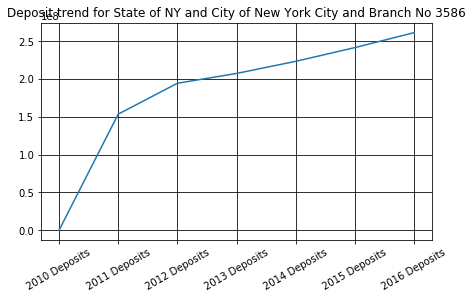

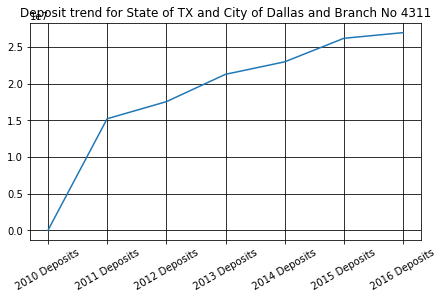

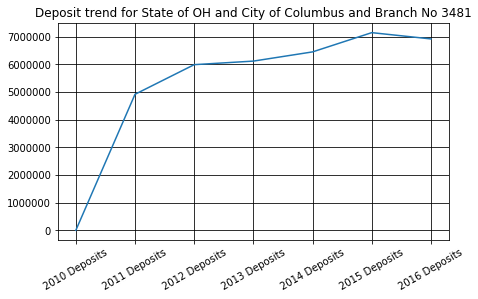

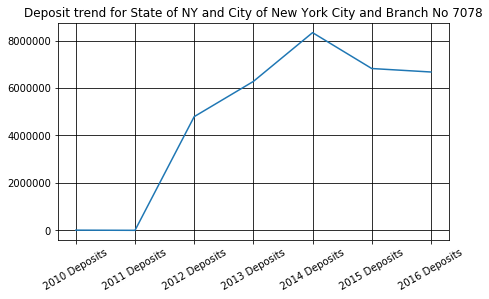

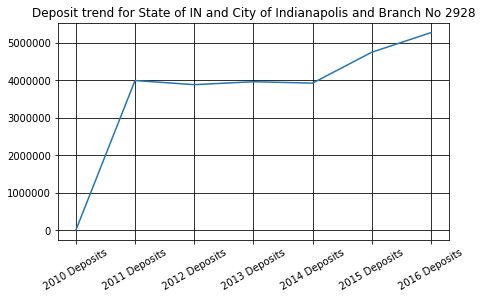

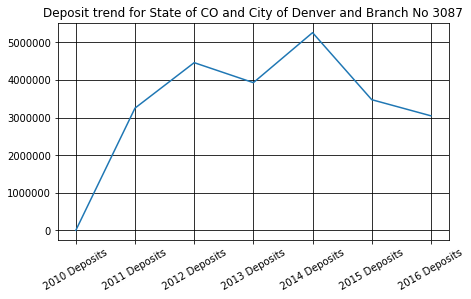

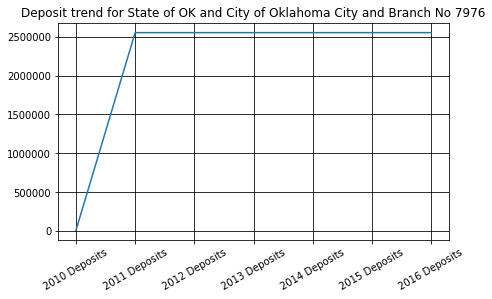

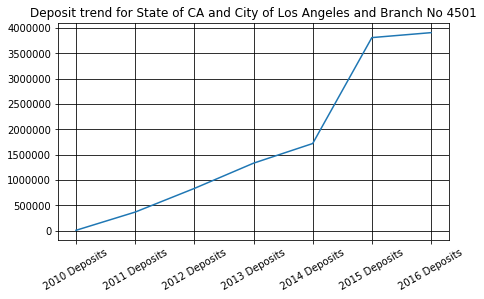

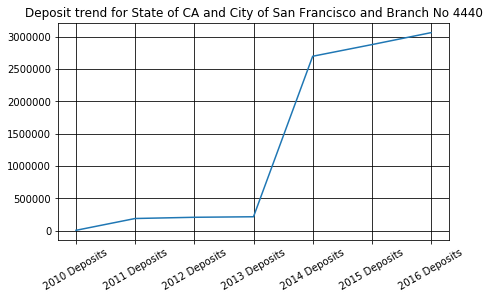

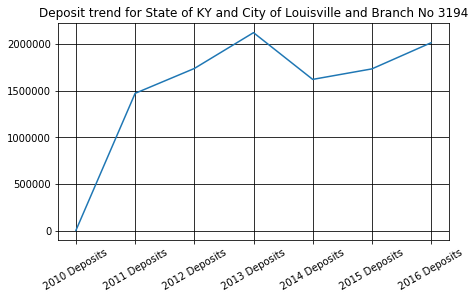

In [32]:
def line_plot(val,col):
    info = val[2:9]
    state = val[0]
    city = val[1]
    br_no = val[2]
    plt.figure(figsize=(7,4))
    plt.grid(color='black')
    plt.plot(col,info)
    plt.xticks(rotation=30)
    plt.title ("Deposit trend for State of %s and City of %s and Branch No %s" %(state,city,br_no))
    #plt.yscale('symlog')
    plt.show()
    
for i in range(top_10.shape[0]):
    line_plot(list(top_10.iloc[i,0:10]),top_10.columns[3:10])

The Observation is:

There is a mixed trend of Upward and downward for the branches. However there is a branch 7976 in the state of OK showing a flat trend between 2011 and 2016 with a sudden rise from 2010.

Between 2013 and 2015 most of the 10 branches touched their peak deposit holding once.

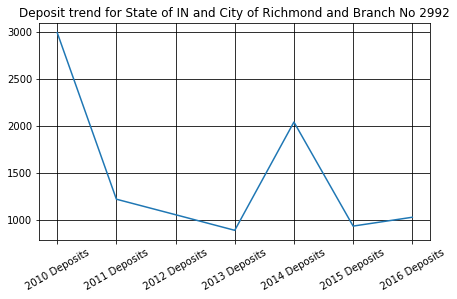

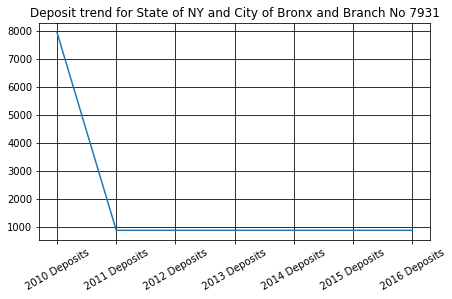

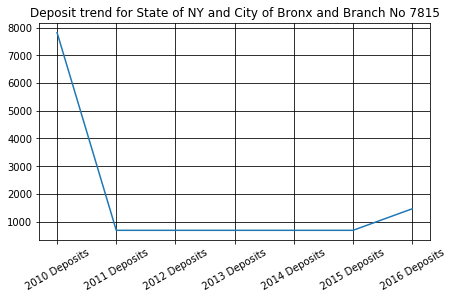

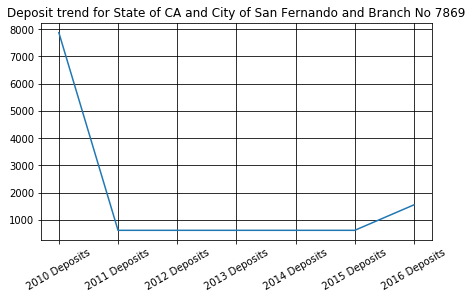

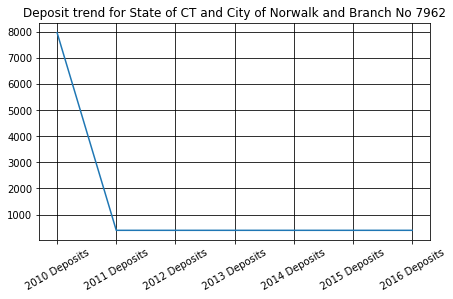

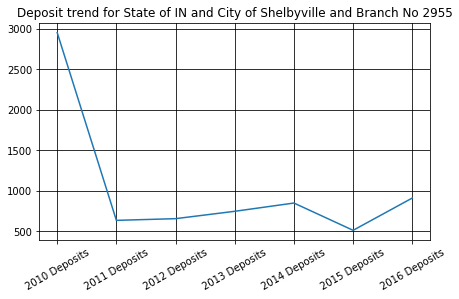

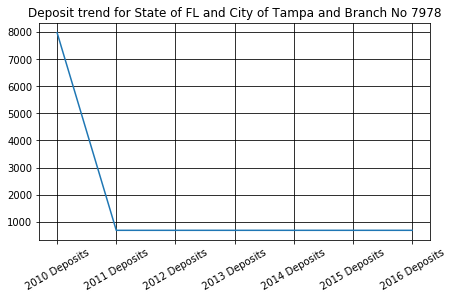

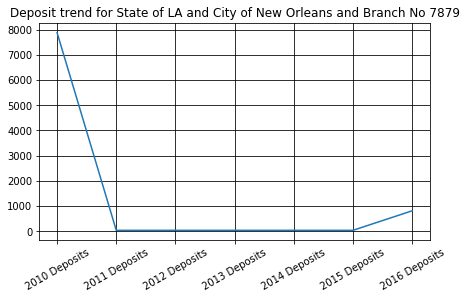

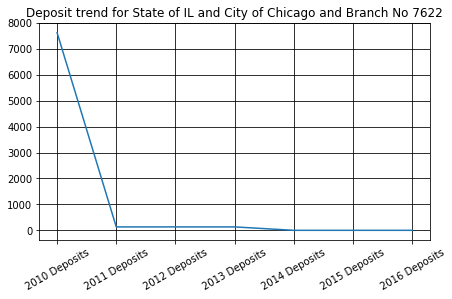

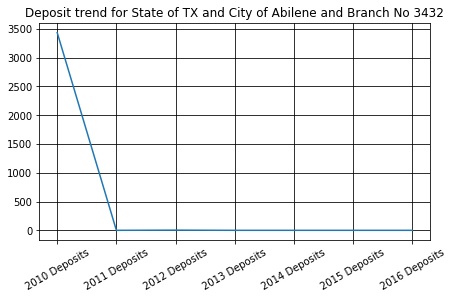

In [33]:
'''
Trend for Least 10 branches with highest Total Deposit so far
'''
tail_10 = e.tail(10).copy()
for i in range(tail_10.shape[0]):
    line_plot(list(tail_10.iloc[i,0:10]),tail_10.columns[3:10])

The Observation is:

Most of the branches showing flat trend for most of the years recorded. However there are multiple branches showing a flat trend between 2011 and 2016 with a sudden fall from 2010.

In [34]:
#Visualizing the data on US Geographical map

In [35]:
'''
Visualizing the data basis Total Deposit per state on US Geographical map
'''

# loading the shape file for US States
us_shp = '/Users/pritigirishvankudre/DayX_Lockdown Practice/Bank Deposit/tl_2017_us_state/tl_2017_us_state.shp'

In [36]:
state_map_df = gpd.read_file(us_shp)

In [37]:
state_map_df.head()

,REGION,DIVISION,STATEFP,STATENS,GEOID,STUSPS,NAME,LSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,3,5,54,01779805,54,WV,West Virginia,00,G4000,A,62265662566,489840834,+38.6472854,-080.6183274,"POLYGON ((-81.74725 39.09538, -81.74635 39.096..."
1,3,5,12,00294478,12,FL,Florida,00,G4000,A,138911437206,31398800291,+28.4574302,-082.4091478,"MULTIPOLYGON (((-82.98748 24.62538, -82.98748 ..."
2,2,3,17,01779784,17,IL,Illinois,00,G4000,A,143784114293,6211277447,+40.1028754,-089.1526108,"POLYGON ((-91.18529 40.63780, -91.17510 40.643..."
3,2,4,27,00662849,27,MN,Minnesota,00,G4000,A,206229176104,18944967530,+46.3158148,-094.1996628,"POLYGON ((-96.78438 46.63050, -96.78434 46.630..."
4,3,5,24,01714934,24,MD,Maryland,00,G4000,A,25150696145,6980371026,+38.9466584,-076.6744939,"POLYGON ((-77.45881 39.22027, -77.45866 39.220..."


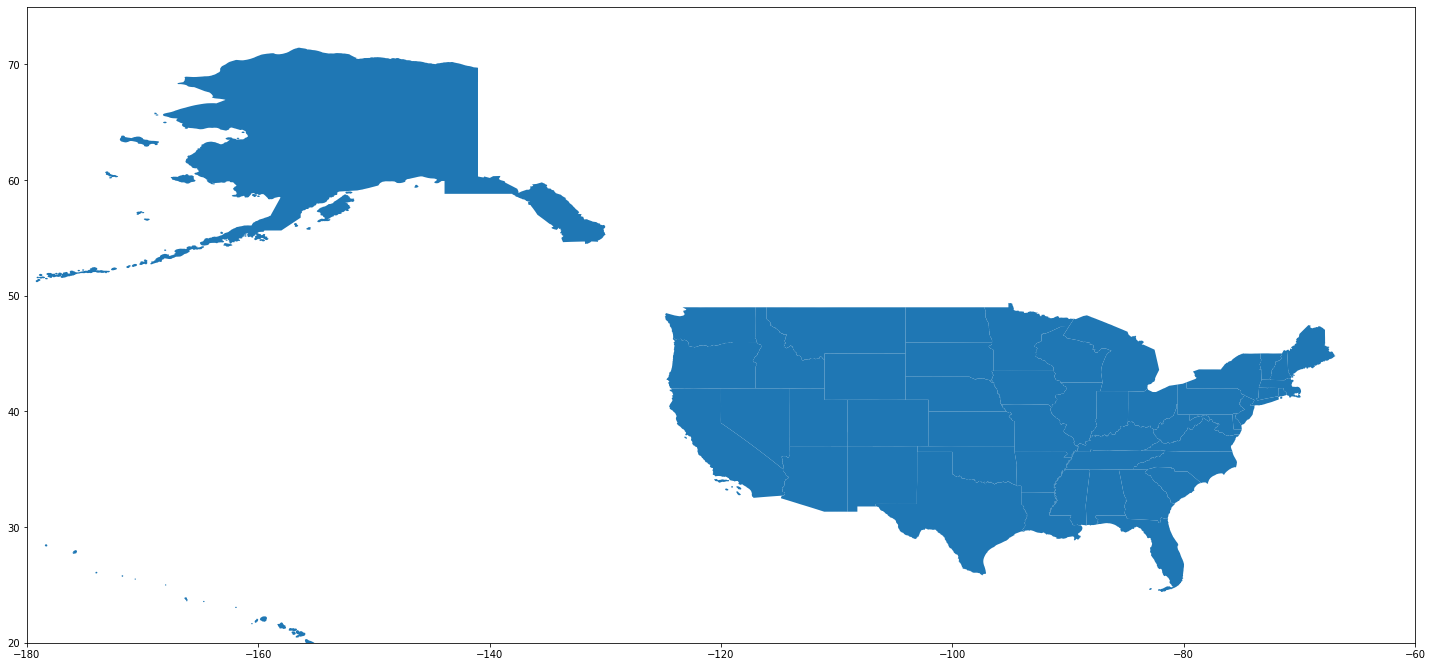

In [38]:
fig, ax = plt.subplots(figsize = (20,15))
state_map_df.plot(ax=ax)
plt.xlim([-180,-60])
plt.ylim([20,75])
plt.tight_layout()
plt.show()

In [39]:
state_map_df.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - NAD83
- bounds: (167.65, 14.92, -47.74, 86.46)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [40]:
merge_data = state_map_df.set_index('STUSPS').join(d.set_index('State'))
#merge_data.fillna(0,inplace=True)
merge_data.head(10)

,REGION,DIVISION,STATEFP,STATENS,GEOID,NAME,LSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,Total Deposit
STUSPS,,,,,,,,,,,,,,,
WV,3,5,54,01779805,54,West Virginia,00,G4000,A,62265662566,489840834,+38.6472854,-080.6183274,"POLYGON ((-81.74725 39.09538, -81.74635 39.096...",NaN
FL,3,5,12,00294478,12,Florida,00,G4000,A,138911437206,31398800291,+28.4574302,-082.4091478,"MULTIPOLYGON (((-82.98748 24.62538, -82.98748 ...",130372723.0
IL,2,3,17,01779784,17,Illinois,00,G4000,A,143784114293,6211277447,+40.1028754,-089.1526108,"POLYGON ((-91.18529 40.63780, -91.17510 40.643...",90039691.0
MN,2,4,27,00662849,27,Minnesota,00,G4000,A,206229176104,18944967530,+46.3158148,-094.1996628,"POLYGON ((-96.78438 46.63050, -96.78434 46.630...",NaN
MD,3,5,24,01714934,24,Maryland,00,G4000,A,25150696145,6980371026,+38.9466584,-076.6744939,"POLYGON ((-77.45881 39.22027, -77.45866 39.220...",NaN
RI,1,1,44,01219835,44,Rhode Island,00,G4000,A,2677997539,1323452846,+41.5974187,-071.5272723,"MULTIPOLYGON (((-71.67881 41.15891, -71.67626 ...",NaN
ID,4,8,16,01779783,16,Idaho,00,G4000,A,214048160737,2393355752,+44.3484222,-114.5588538,"POLYGON ((-116.89971 44.84061, -116.89967 44.8...",3310905.0
NH,1,1,33,01779794,33,New Hampshire,00,G4000,A,23187445452,1028643155,+43.6726907,-071.5843145,"POLYGON ((-72.32990 43.60021, -72.32984 43.600...",NaN
NC,3,5,37,01027616,37,North Carolina,00,G4000,A,125919712692,13470113896,+35.5397100,-079.1308636,"POLYGON ((-82.41674 36.07283, -82.41660 36.073...",NaN


In [41]:
# set a variable that will call whatever column we want to visualise on the map
variable = 'Total Deposit'

In [42]:
# set the range for the choropleth
#vmin, vmax = merge_data['Total Deposit'].min(), merge_data['Total Deposit'].max()

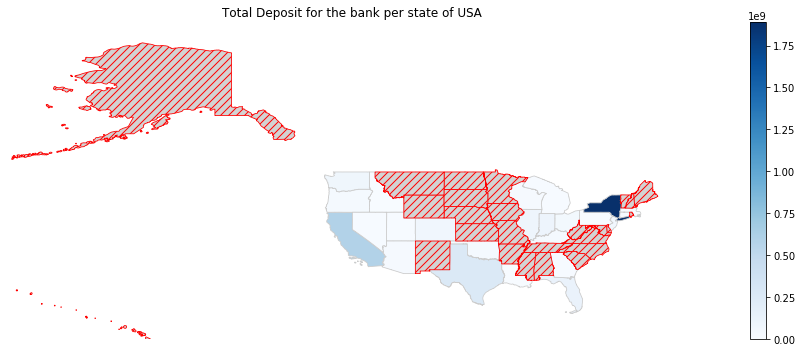

In [43]:
# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(15,5))
merge_data.plot(column=variable, cmap='Blues', legend=True, linewidth=0.8, ax=ax, edgecolor='0.8',
               missing_kwds={"color": "lightgrey","edgecolor": "red","hatch": "///","label": "Missing values",})
plt.xlim([-180,-60])
plt.ylim([20,75])
# Create colorbar as a legend
#sm = plt.cm.ScalarMappable(cmap='Blues',norm=plt.Normalize(vmin=vmin, vmax=vmax))
# add the colorbar to the figure
#cbar = fig.colorbar(sm)
ax.axis('Off')
plt.title("Total Deposit for the bank per state of USA")
plt.tight_layout()
plt.show()

The Observation is:

> Bank branch presence is not there in most of the Central parts of America on mainland. The state of NY is the most with deposits while rest others are in the mid or low range in terms of total deposits. So the State/County/City of the branch seems to play a role in predicting the deposits a brnach could hold.

# Model Building to predict the deposit in the year 2016

The objective is to predict the deposit amount for the year of 2016, hence it is a regression type problem where importance would be have increased accuracy and reduced error.

In [44]:
deposit_data.head()

,Main Office,Branch Number,Established Date,Acquired Date,City,County,State,2010 Deposits,2011 Deposits,2012 Deposits,2013 Deposits,2014 Deposits,2015 Deposits,2016 Deposits
0,0,2866,110.0,1,Wales,Waukesha,WI,21386.0,23981.0,24825.0,26908.0,30681.0,30680.0,37564
1,0,2867,110.0,1,Germantown,Washington,WI,55454.0,56564.0,64732.0,73523.0,81357.0,89270.0,106177
2,0,2868,113.0,1,Brookfield,Waukesha,WI,90882.0,104300.0,125038.0,125906.0,132501.0,137363.0,145054
3,0,2869,84.0,1,Pewaukee,Waukesha,WI,45674.0,49288.0,53251.0,70402.0,74742.0,73837.0,85996
4,0,2870,57.0,1,Waukesha,Waukesha,WI,64181.0,72217.0,69920.0,80703.0,75971.0,73225.0,81706


The location of the branch in terms of City/County/State is uniquely identified by the branch number, hence we could focus on adding some weightage to the Branch Number.

Assigning weightage to Branch Number with respect to GNIS ID of the City

In [45]:
city_map_df = gpd.read_file('/Users/pritigirishvankudre/DayX_Lockdown Practice/Bank Deposit/data/citiesx010g.shp')

In [46]:
city_map_df.head()

,GNIS_ID,ANSICODE,FEATURE,FEATURE2,NAME,POP_2010,COUNTY,COUNTYFIPS,STATE,STATE_FIPS,LATITUDE,LONGITUDE,PopPlLat,PopPlLong,ELEV_IN_M,ELEV_IN_FT,geometry
0,1028750.0,1036000,Civil,-999,Dunseith,773.0,Rolette,079,ND,38,48.813057,-100.060968,48.813057,-100.060968,520.0,1706.0,POINT (-100.06097 48.81306)
1,1030349.0,1036174,Civil,-999,Mylo,20.0,Rolette,079,ND,38,48.635278,-99.618756,48.635278,-99.618756,504.0,1654.0,POINT (-99.61876 48.63528)
2,1027718.0,1035912,Civil,-999,Antler,27.0,Bottineau,009,ND,38,48.970853,-101.282380,48.970853,-101.282380,468.0,1535.0,POINT (-101.28238 48.97085)
3,1028083.0,1035936,Civil,County Seat,Bottineau,2211.0,Bottineau,009,ND,38,48.827230,-100.445698,48.827230,-100.445698,499.0,1637.0,POINT (-100.44570 48.82723)
4,1029080.0,1036050,Civil,-999,Gardena,29.0,Bottineau,009,ND,38,48.700837,-100.497639,48.700837,-100.497639,447.0,1467.0,POINT (-100.49764 48.70084)


In [47]:
deposit_data_mod = deposit_data.merge(city_map_df, left_on = ['City','County'], right_on = ['NAME','COUNTY'])
deposit_data_mod.head()

,Main Office,Branch Number,Established Date,Acquired Date,City,County,State,2010 Deposits,2011 Deposits,2012 Deposits,2013 Deposits,2014 Deposits,2015 Deposits,2016 Deposits,GNIS_ID,ANSICODE,FEATURE,FEATURE2,NAME,POP_2010,COUNTY,COUNTYFIPS,STATE,STATE_FIPS,LATITUDE,LONGITUDE,PopPlLat,PopPlLong,ELEV_IN_M,ELEV_IN_FT,geometry
0,0,2866,110.0,1,Wales,Waukesha,WI,21386.0,23981.0,24825.0,26908.0,30681.0,30680.0,37564,1576156.0,1584341,Civil,-999,Wales,2549.0,Waukesha,133,WI,55,43.004455,-88.376763,43.004455,-88.376763,305.0,1001.0,POINT (-88.37676 43.00445)
1,0,2867,110.0,1,Germantown,Washington,WI,55454.0,56564.0,64732.0,73523.0,81357.0,89270.0,106177,1565495.0,1583269,Civil,-999,Germantown,19749.0,Washington,131,WI,55,43.228617,-88.110369,43.228617,-88.110369,264.0,866.0,POINT (-88.11037 43.22862)
2,0,2868,113.0,1,Brookfield,Waukesha,WI,90882.0,104300.0,125038.0,125906.0,132501.0,137363.0,145054,1562234.0,1582867,Civil,-999,Brookfield,37920.0,Waukesha,133,WI,55,43.060567,-88.106479,43.060567,-88.106479,253.0,830.0,POINT (-88.10648 43.06057)
3,0,2872,57.0,1,Brookfield,Waukesha,WI,78437.0,87150.0,102144.0,119436.0,133107.0,142844.0,163181,1562234.0,1582867,Civil,-999,Brookfield,37920.0,Waukesha,133,WI,55,43.060567,-88.106479,43.060567,-88.106479,253.0,830.0,POINT (-88.10648 43.06057)
4,0,2869,84.0,1,Pewaukee,Waukesha,WI,45674.0,49288.0,53251.0,70402.0,74742.0,73837.0,85996,1571279.0,1583916,Civil,-999,Pewaukee,13195.0,Waukesha,133,WI,55,43.064732,-88.243704,43.080565,-88.261205,249.0,817.0,POINT (-88.24370 43.06473)


In [48]:
deposit_data_mod.drop(['City','County','State','ANSICODE','FEATURE','FEATURE2','NAME','POP_2010','COUNTY',
                       'COUNTYFIPS','STATE','STATE_FIPS','LATITUDE','LONGITUDE','PopPlLat','PopPlLong',
                       'ELEV_IN_M','ELEV_IN_FT','geometry'], axis=1, inplace=True)
deposit_data_mod.head()

,Main Office,Branch Number,Established Date,Acquired Date,2010 Deposits,2011 Deposits,2012 Deposits,2013 Deposits,2014 Deposits,2015 Deposits,2016 Deposits,GNIS_ID
0,0,2866,110.0,1,21386.0,23981.0,24825.0,26908.0,30681.0,30680.0,37564,1576156.0
1,0,2867,110.0,1,55454.0,56564.0,64732.0,73523.0,81357.0,89270.0,106177,1565495.0
2,0,2868,113.0,1,90882.0,104300.0,125038.0,125906.0,132501.0,137363.0,145054,1562234.0
3,0,2872,57.0,1,78437.0,87150.0,102144.0,119436.0,133107.0,142844.0,163181,1562234.0
4,0,2869,84.0,1,45674.0,49288.0,53251.0,70402.0,74742.0,73837.0,85996,1571279.0


In [49]:
deposit_data_mod['Branch Number'] = deposit_data_mod['GNIS_ID']/deposit_data_mod['Branch Number']
deposit_data_mod.drop(['GNIS_ID'],axis=1,inplace=True)
deposit_data_mod.head()

,Main Office,Branch Number,Established Date,Acquired Date,2010 Deposits,2011 Deposits,2012 Deposits,2013 Deposits,2014 Deposits,2015 Deposits,2016 Deposits
0,0,549.949756,110.0,1,21386.0,23981.0,24825.0,26908.0,30681.0,30680.0,37564
1,0,546.039414,110.0,1,55454.0,56564.0,64732.0,73523.0,81357.0,89270.0,106177
2,0,544.711994,113.0,1,90882.0,104300.0,125038.0,125906.0,132501.0,137363.0,145054
3,0,543.953343,57.0,1,78437.0,87150.0,102144.0,119436.0,133107.0,142844.0,163181
4,0,547.674800,84.0,1,45674.0,49288.0,53251.0,70402.0,74742.0,73837.0,85996


Assumptions for Linear Regression
> The first assumption of simple linear regression is that the two variables in question should have a linear relationship.

> The second assumption of linear regression is that all the variables in the data set should be multivariate normal. In other words, it suggests that the linear combination of the random variables should have a normal distribution.

> Another critical assumption of multiple linear regression is that there should not be much multicollinearity in the data.

> One of the critical assumptions of multiple linear regression is that there should be no autocorrelation in the data. When the residuals are dependent on each other, there is autocorrelation.

> Finally, the fifth assumption of a classical linear regression model is that there should be homoscedasticity among the data. The data is said to homoscedastic when the residuals are equal across the line of regression. In other words, the variance is equal.

In [50]:
# Residual Plots
def regression_residual_plots(model_fit, dependent_var, data, size=[10,10]):
    """
    This function requires:
        import matplotlib.pyplot as plt
        import statsmodels.api as sm
    
    Arguments:
    model_fit: It takes a fitted model as input.
        Obtainable through Statsmodels regression: 
            model_fit = sm.OLS(endog= DEPENDENT VARIABLE, exog= INDEPENDENT VARIABLE).fit()
    dependent_var: string of the pandas column used as the model dependent variable.
    data: pandas dataset where the dependent variable is located. The model data.
    size: default [10,10]. Updates the [width, height], inputed in matplotlibs figsize = [10,10]
        
    Ive only run it on simple, non-robust, ordinary least squares models,
    but these metrics are standard for linear models.
    """
    
    # Extract relevant regression output for plotting
    # fitted values (need a constant term for intercept)
    model_fitted_y = model_fit.fittedvalues
    # model residuals
    model_residuals = model_fit.resid
    # normalized residuals
    model_norm_residuals = model_fit.get_influence().resid_studentized_internal
    # absolute squared normalized residuals
    model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))
    # absolute residuals
    model_abs_resid = np.abs(model_residuals)
    # leverage, from statsmodels internals
    model_leverage = model_fit.get_influence().hat_matrix_diag
    # cook's distance, from statsmodels internals
    model_cooks = model_fit.get_influence().cooks_distance[0]

    ########################################################################
    # Plot Size
    fig = plt.figure(figsize=size)
    
    # Residual vs. Fitted
    ax = fig.add_subplot(2, 2, 1) # Top Left
    sns.residplot(model_fitted_y, dependent_var, data=data, 
                              lowess=True, 
                              scatter_kws={'alpha': 0.5}, 
                              line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8},
                 ax=ax)
    ax.set_title('Residuals vs Fitted')
    ax.set_xlabel('Fitted values')
    ax.set_ylabel('Residuals')

    # Annotations of Outliers
    abs_resid = model_abs_resid.sort_values(ascending=False)
    abs_resid_top_3 = abs_resid[:3]
    for i in abs_resid_top_3.index:
        ax.annotate(i, xy=(model_fitted_y[i], model_residuals[i]));

    ########################################################################
    # Normal Q-Q
    ax = fig.add_subplot(2, 2, 2) # Top Right
    QQ = sm.ProbPlot(model_norm_residuals)
    QQ.qqplot(line='45', alpha=0.5, color='#4C72B0', lw=1, ax=ax)
    ax.set_title('Normal Q-Q')
    ax.set_xlabel('Theoretical Quantiles')
    ax.set_ylabel('Standardized Residuals')

    # Annotations of Outliers
    #abs_norm_resid = np.flip(np.argsort(np.abs(model_norm_residuals)), 0)
    #abs_norm_resid_top_3 = abs_norm_resid[:3]
    #for r, i in enumerate(abs_norm_resid_top_3):
    #    ax.annotate(i, xy=(np.flip(QQ.theoretical_quantiles, 0)[r],model_norm_residuals[i]));

    ########################################################################
    # Scale-Location Plot
    ax = fig.add_subplot(2, 2, 3) # Bottom Left
    plt.scatter(model_fitted_y, model_norm_residuals_abs_sqrt, alpha=0.5)
    sns.regplot(model_fitted_y, model_norm_residuals_abs_sqrt, 
                scatter=False, 
                ci=False, 
                lowess=True,
                line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8}, ax=ax)
    ax.set_title('Scale-Location')
    ax.set_xlabel('Fitted values')
    ax.set_ylabel('$\sqrt{|Standardized Residuals|}$');
    
    # Annotations of Outliers
    #abs_sq_norm_resid = np.flip(np.argsort(model_norm_residuals_abs_sqrt), 0)
    #abs_sq_norm_resid_top_3 = abs_sq_norm_resid[:3]
    #for i in abs_norm_resid_top_3:
    #    ax.annotate(i, xy=(model_fitted_y[i], model_norm_residuals_abs_sqrt[i]));

    ########################################################################  
    # Cook's Distance Plot
    ax = fig.add_subplot(2, 2, 4) # Bottom Right
    plt.scatter(model_leverage, model_norm_residuals, alpha=0.5)
    sns.regplot(model_leverage, model_norm_residuals, 
                scatter=False, 
                ci=False, 
                lowess=True,
                line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8},
               ax=ax)
    ax.set_xlim(0, 0.20)
    ax.set_ylim(-3, 5)
    ax.set_title('Residuals vs Leverage')
    ax.set_xlabel('Leverage')
    ax.set_ylabel('Standardized Residuals')

    # Annotations
    #leverage_top_3 = np.flip(np.argsort(model_cooks), 0)[:3]
    #for i in leverage_top_3:
    #    ax.annotate(i, xy=(model_leverage[i],model_norm_residuals[i]))

    # Shenanigans for Cook's distance contours
    def graph(formula, x_range, label=None):
        x = x_range
        y = formula(x)
        plt.plot(x, y, label=label, lw=1, ls='--', color='red')
    p = len(model_fit.params) # number of model parameters
    graph(lambda x: np.sqrt((0.5 * p * (1 - x)) / x), 
          np.linspace(0.001, 0.200, 50), 
          'Cook\'s distance') # 0.5 line
    graph(lambda x: np.sqrt((1 * p * (1 - x)) / x), 
          np.linspace(0.001, 0.200, 50)) # 1 line
    plt.legend(loc='upper right')
    plt.savefig('residual_plots.png',bbox_inches='tight')
    plt.xscale('symlog')
    plt.yscale('symlog')
    plt.show()

/Users/pritigirishvankudre/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Residual Plots Function Ready


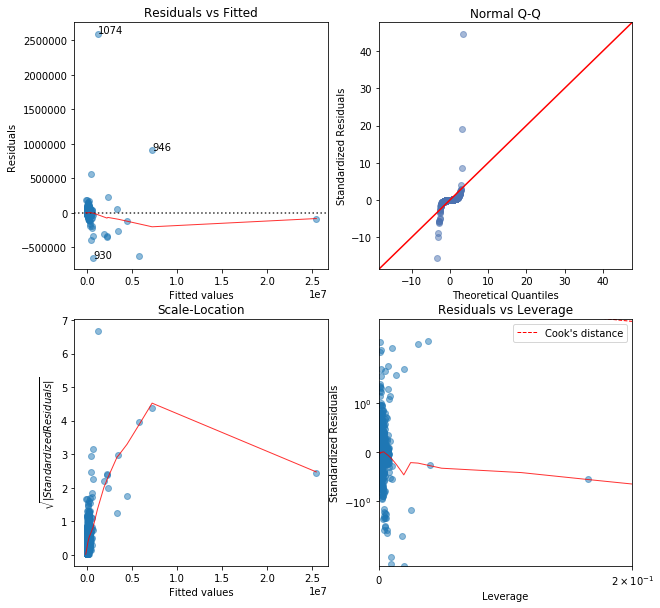

In [51]:
#Fitting the data into a stats model model and checking on the assumptions of linear regression

x = deposit_data_mod.drop('2016 Deposits', axis=1)
y = deposit_data_mod['2016 Deposits']

x_train,x_test,y_train,y_test = train_test_split(x, y, train_size=0.7, random_state=7)

# to add constant 1 column which we used for matrix multiplication, basically intercept
x_train = sm.add_constant(x_train)

lr_model_sm = sm.OLS(y_train,x_train).fit()

print("Residual Plots Function Ready")
regression_residual_plots(lr_model_sm, y_train, deposit_data_mod)

Let's understand from above Residual Plot Test whether data is suitable to apply with Linear Regression models

> The first assumption of simple linear regression is that the two variables (dependent and independent) in question should have a linear relationship.

>> As per residual versus predicted (fitted) values plot, the points are roughly distributed symmetrically around the horizontal line. No specific pattern is evident (which means points are homoskedostic; had it been there any shape evident it would be termed as hetroskedastic). There is a small bowed pattern, indicating that model makes systematic errors whenever it is making usually large or small predictions. To correct this we can think of using transformation (basis right/left skewness of data).

> The second assumption of linear regression is that all the variables in the data set should be multivariate normal. In other words, it suggests that the linear combination of the random variables should have a normal distribution.

>> This q-q or quantile-quantile is a scatter plot which helps us validate the assumption of normal distribution in a data set. Using this plot we can infer if the data comes from a normal distribution. in above case plot shows fairly straight line. The solution to correct deviations to straight line would be to undertake transformation of data points.

> The fifth assumption of a classical linear regression model is that there should be homoscedasticity among the data. The data is said to homoscedastic when the residuals are equal across the line of regression. In other words, the variance is equal.

>> This plot is also used to detect homoskedasticity (assumption of equal variance). It shows how the residual are spread along the range of predictors. It’s similar to residual vs fitted value plot except it uses standardized residual values. Ideally, there should be no discernible pattern in the plot. This would imply that errors are normally distributed. But, in case, if the plot shows any discernible pattern (probably a funnel shape), it would imply non-normal distribution of errors. In the above Scale-Location plot we do not see any pattern evident.

> Residual versus Levarage plot also known as Cook's Distance attempts to identify the points which have more influence than other points. Such influential points tends to have a sizable impact of the regression line. In other words, adding or removing such points from the model can completely change the model statistics. On above figure the points are not very close to the Cook's line (dotted red line).

Basis above observation let us use transformation technique to treat the data.

In [52]:
def transform(deposit_data_mod,i):    
    deposit_data_mod[i] = 1/(np.sqrt(deposit_data_mod[i])+1)
    return deposit_data_mod[i]

for i in ['2010 Deposits','2011 Deposits','2012 Deposits','2013 Deposits','2014 Deposits','2015 Deposits','2016 Deposits']:
    transform(deposit_data_mod,i)
    
deposit_data_mod.head()

,Main Office,Branch Number,Established Date,Acquired Date,2010 Deposits,2011 Deposits,2012 Deposits,2013 Deposits,2014 Deposits,2015 Deposits,2016 Deposits
0,0,549.949756,110.0,1,0.006792,0.006416,0.006307,0.006059,0.005677,0.005677,0.005133
1,0,546.039414,110.0,1,0.004229,0.004187,0.003915,0.003674,0.003494,0.003336,0.003060
2,0,544.711994,113.0,1,0.003306,0.003087,0.002820,0.002810,0.002740,0.002691,0.002619
3,0,543.953343,57.0,1,0.003558,0.003376,0.003119,0.002885,0.002733,0.002639,0.002469
4,0,547.674800,84.0,1,0.004657,0.004484,0.004315,0.003755,0.003644,0.003667,0.003398


Residual Plots Function Ready


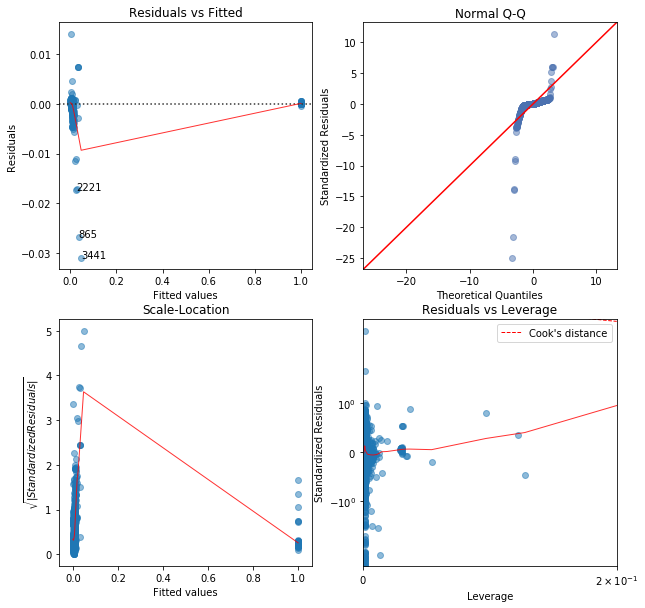

In [53]:
#Fitting the data into a stats model model and checking on the assumptions of linear regression

x = deposit_data_mod.drop('2016 Deposits', axis=1)
y = deposit_data_mod['2016 Deposits']

x_train,x_test,y_train,y_test = train_test_split(x, y, train_size=0.7, random_state=7)

# to add constant 1 column which we used for matrix multiplication, basically intercept
x_train = sm.add_constant(x_train)

lr_model_sm = sm.OLS(y_train,x_train).fit()

print("Residual Plots Function Ready")
regression_residual_plots(lr_model_sm, y_train, deposit_data_mod)

The effect of log transformation is visible above.

Verifying for Multicollinearity

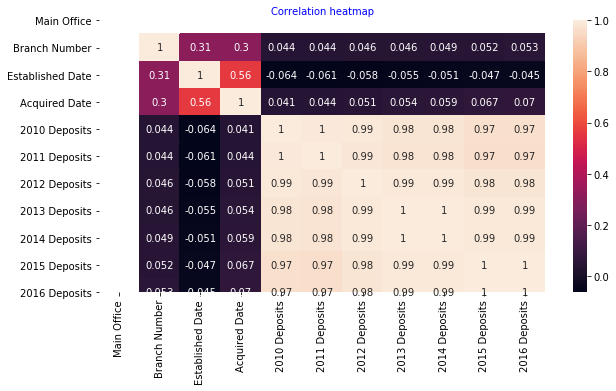

In [54]:
fig = plt.figure(figsize=(10,5))
sns.heatmap(deposit_data_mod.corr(),annot=True)
plt.title('Correlation heatmap', fontsize=10, color='blue')
plt.show()

Deposit Amount details are highly correlated to each other basis year with respect to each other as well as with 2016. Branch Location, Age of the branch, Acquired status of the branch does not seem to impact the deposit amount.

In [55]:
deposit_data_mod.skew()

Main Office         0.000000
Branch Number       1.298400
Established Date    1.483248
Acquired Date      -0.513905
2010 Deposits       8.062150
2011 Deposits       8.128584
2012 Deposits       7.997930
2013 Deposits       7.931411
2014 Deposits       7.941813
2015 Deposits       8.031864
2016 Deposits       8.033739
dtype: float64

# Implementing Linear Regression Model

In [56]:
# Applying the model with all fields

x = deposit_data_mod.drop('2016 Deposits', axis=1)
y = deposit_data_mod['2016 Deposits']

x_train,x_test,y_train,y_test = train_test_split(x, y, train_size=0.7, random_state=7)

In [57]:
# Looking for best parameter tunning

# Defining the parameters
grid={'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}

# Defining the model
linReg=LinearRegression()

lr=GridSearchCV(linReg,param_grid=grid,cv=15)
lr.fit(x_train,y_train)

print("tuned hpyerparameters :(best parameters) ",lr.best_params_)
print("accuracy :",lr.best_score_)

tuned hpyerparameters :(best parameters)  {'copy_X': True, 'fit_intercept': True, 'normalize': True}
accuracy : 0.9997624710933637


In [58]:
# Defining the algorithm basis tunned parameters

linReg=LinearRegression(fit_intercept=True, normalize=True, copy_X=True)

linReg.fit(x_train,y_train)
print ("Accuracy score for Linear Regression Model %.2f" %(linReg.score(x_train,y_train)*100))

# Predicting the values for unseen/test data
pred = linReg.predict(x_test)

# Root Mean Square Error for the algorithm
print ("Root Mean Square Error for Linear Regression Model %.2f" %(rmse(pred,y_test)))

Accuracy score for Linear Regression Model 99.99
Root Mean Square Error for Linear Regression Model 0.00


The RMSE is the square root of the variance of the residuals. It indicates the absolute fit of the model to the data–how close the observed data points are to the model’s predicted values. Lower values of RMSE indicate better fit. RMSE is a good measure of how accurately the model predicts the response, and it is the most important criterion for fit if the main purpose of the model is prediction.

# Implementing RandomForest Regressor

In [59]:
# Defining the model
ranFo=RandomForestRegressor(n_estimators=100)

ranFo.fit(x_train,y_train)
print ("Accuracy score for RandomForest Regressor Model %.2f" %(ranFo.score(x_train,y_train)*100))

# Predicting the values for unseen/test data
pred = ranFo.predict(x_test)

# Root Mean Square Error for the algorithm
print ("Root Mean Square Error for RandomForest Regressor Model %.2f" %(rmse(pred,y_test)))

Accuracy score for RandomForest Regressor Model 99.89
Root Mean Square Error for RandomForest Regressor Model 0.00
